# Tutorial 22: Data-driven corrections in PPE-ROM

## Importing full order data and POD output before online simulation

We import useful modules and set the torch and numpy seeds:

In [1]:
import numpy as np
import torch
from torch import nn
import matplotlib
import matplotlib.pyplot as plt
import scipy.io
from scipy.optimize import fsolve
import TrainNet
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from scipy.linalg import svdvals
from sklearn import preprocessing
import os.path
from scipy.interpolate import Rbf
from os import path
from scipy.interpolate import griddata
from sklearn.utils.extmath import randomized_svd
from matplotlib.ticker import MaxNLocator
import math
import cvxpy as cp
from DataPPE import bt_mat
plt.rcParams.update({
    "text.usetex": True,
    "font.family": 'STIXGeneral',
    'mathtext.fontset': 'stix'})
matplotlib.rcParams.update({'font.size': 16})

torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(0)

We here define a function to read the matrices data files.

In [2]:
def readFile(fileName):
    fileObj = open(fileName, "r") #opens the file in read mode
    words = fileObj.read().splitlines() #puts the file into an array
    words.pop(0); words.pop(0)
    words = [float(i) for i in words]
    fileObj.close()
    return words

def read_txt(file):
    f = open(file)
    triplets = f.read().split()
    for i in range(0,len(triplets)): triplets[i]=triplets[i].split(',')
    A = np.array(triplets, dtype=np.float32)
    return A

Then, the matrices and tensors evaluated starting from the POD modes and stored folder *DataPPE* are here imported.

In [3]:
B = np.load("DataPPE/B.npy") #Nu x Nu
BC1 = np.load("DataPPE/BC1.npy")
BC2 = np.load("DataPPE/BC2.npy")
BC3 = np.load("DataPPE/BC3.npy")
Bt = bt_mat.bt #Nu x Nu
M = np.load("DataPPE/M.npy")  
C = np.load("DataPPE/C.npy")   #Nu x Nu x Nu   
K = np.load("DataPPE/K.npy")   #Nu x Np
G = np.load("DataPPE/G.npy")   #Np x Nu x Nu
D = np.load("DataPPE/D.npy")    #Np x Np
Ct1 = np.load("DataPPE/ct1.npy") 
Ct2 = np.load("DataPPE/ct2.npy")
Ct1Ave = np.load("DataPPE/ct1Ave.npy")
Ct2Ave = np.load("DataPPE/ct2Ave.npy")
Ct1PPE = np.load("DataPPE/ct1PPE.npy")
Ct2PPE = np.load("DataPPE/ct2PPE.npy")
Ct1PPEAve = np.load("DataPPE/ct1PPEAve.npy")
Ct2PPEAve = np.load("DataPPE/ct2PPEAve.npy")
coeffU = np.load("DataPPE/coeefs.npy")
coeffP = np.load("DataPPE/coeefsP.npy")
coeffNut = np.load("DataPPE/coeefsNut.npy")
mod_U = np.load("DataPPE/modU.npy")
mod_P = np.load("DataPPE/modP.npy")
Eig_U = readFile("DataPPE/Eigenvalues_U")

CtTot = Ct1 + Ct2  
CtPPETot = Ct1PPE + Ct2PPE
CtAveTot = Ct1Ave + Ct2Ave
CtPPEAveTot = Ct1PPEAve + Ct2PPEAve

## Definition of the PPE-ROM class: online stage

Now the ROM class for the Poisson reduced approach is defined. Here the data-driven correction terms are computed and the reduced system including these extra-terms is defined. The reduced dynamical system is solved in two different cases: with and without the eddy-viscosity turbulence modelling. 

We here choose a reduced number of velocity and pressure modes ($N_u$ and $N_p$, respectively) for the reduced model. The modes are denoted as: $(\boldsymbol{\phi_i})_{i=1}^{N_u}$ and $(\chi_i)_{i=1}^{N_p}$.

The projections of the full order fields onto the subspace generated by these modes are:

\begin{equation}
\mathbf{\bar{u}}_r = \sum_{i=1}^{N_u+N_{sup}} a^{snap}_i \boldsymbol{\phi_i} \text{ and } \bar{p}_r = \sum_{i=1}^{N_u} b^{snap}_i \chi_i,
\end{equation}
where the matrices of the coefficients $a^{snap}_i$ and $b^{snap}_i$ are evaluated from the POD and stored in the snapshots matrices *snapU* and *snapP*.

The reduced approximated fields are computed at each time step by solving a dynamical system with unknowns $\mathbf{a}=(a_i)_{i=1}^{N_u}$ and $\mathbf{b}=(b_i)_{i=1}^{N_p}$, which are the vectors of coefficients for velocity and pressure. The reduced approximated fields are defined as:
\begin{equation}
\mathbf{u}_r = \sum_{i=1}^{N_u} a_i(t) \boldsymbol{\phi_i} \text{ and } \bar{p}_r = \sum_{i=1}^{N_u} b_i(t) \chi_i
\end{equation}


The standard PPE reduced system, obtained with a POD-Galerkin approach, is the following:
\begin{equation}
    \begin{cases}
    \mathbf{M} \dot{\mathbf{a}}=\nu(\mathbf{B}+\mathbf{B_T})\mathbf{a}-\mathbf{a}^T \mathbf{C} \mathbf{a}-\mathbf{H}\mathbf{b}+\tau \left( \sum_{k=1}^{N_{\text{BC}}}(U_{\text{BC},k}\mathbf{D}^k-\mathbf{E}^k \mathbf{a})\right) + \boldsymbol{\tau}_u(\mathbf{a}, \mathbf{b}),\\
    \mathbf{D}\mathbf{b} + \mathbf{a}^T \mathbf{G} \mathbf{a} -\nu \mathbf{N} \mathbf{a} -\mathbf{L} + \boldsymbol{\tau}_p(\mathbf{a}, \mathbf{b})=\mathbf{0}.
    \end{cases}
\end{equation}

Matrices appearing in the previous system are defined as:
\begin{equation}
\begin{split}
&(\mathbf{M})_{ij}=(\boldsymbol{\phi}_i,\boldsymbol{\phi}_j)_{L^2(\Omega)}, \quad (\mathbf{B})_{ij}=(\boldsymbol{\phi}_i,\nabla \cdot \nabla \boldsymbol{\phi}_j)_{L^2(\Omega)}, \\
&(\mathbf{B_T})_{ij}=(\boldsymbol{\phi}_i,\nabla \cdot (\nabla \boldsymbol{\phi}_j)^T)_{L^2(\Omega)},\quad (\mathbf{C})_{ijk}=(\boldsymbol{\phi}_i,\nabla \cdot (\boldsymbol{\phi}_j \otimes \boldsymbol{\phi}_k))_{L^2(\Omega)}, \quad (\mathbf{H})_{ij}=(\boldsymbol{\phi}_i,\nabla \chi_j)_{L^2(\Omega)}\,, \\
&(\mathbf{D})_{ij}=(\nabla \chi_i,\nabla \chi_j)_{L^2(\Omega)}, \quad 
(\mathbf{G})_{ijk}=(\nabla \chi_i,\nabla \cdot (\boldsymbol{\phi}_j \otimes \boldsymbol{\phi}_k))_{L^2(\Omega)}, \\ &(\mathbf{N})_{ij}=(\mathbf{n} \times \nabla \chi_i,\nabla \boldsymbol{\phi}_j)_{\Gamma}, \quad (\mathbf{L})_{ij}=(\chi_i,\mathbf{n} \cdot \boldsymbol{R}_t)_{\Gamma}\, .
\end{split}
\end{equation}

The term $\tau \left( \sum_{k=1}^{N_{\text{BC}}}(U_{\text{BC},k}\mathbf{D}^k-\mathbf{E}^k \mathbf{a})\right)$ is a penalization term used to enforce the Dirichlet boundary conditions at the reduced order level. In particular, $N_{\text{BC}}$ is the number of velocity boundary conditions on $k $ different parts of the Dirichlet boundary; $U_{\text{BC},k}$ is the velocity non-zero component at the $k$-th part of the Dirichlet boundary; $\tau$ is a penalization factor, matrices $\mathbf{E}^k$ and vectors $\mathbf{D}^k$ are defined as:
\begin{equation} (\mathbf{E}^k)_{ij}=(\boldsymbol{\phi}_i, \boldsymbol{\phi}_j)_{L^2(\Gamma_{D_k})}, \quad (\mathbf{D}^k)_{i}=(\boldsymbol{\phi}_i)_{\Gamma_{D_k}}, \text{ for all }k=1,...,N_{\text{BC}}.\end{equation}

The time derivative is computed with a second order backward time scheme.

In the first equation the term $\boldsymbol{\tau^u}(\mathbf{a}, \mathbf{b})$ is a velocity correction term and the term $\boldsymbol{\tau^p}(\mathbf{a}, \mathbf{b})$ is a pressure correction term introduced to improve the results in terms of pressure accuracy. In this tutorial the two terms are evaluated by solving a unique least squares problem. 

1. First of all, the exact correction term is found from available data, at each time step:

The exact term is:

\begin{equation}
    \boldsymbol{\tau}_{\text{tot}}^{\text{exact}}(t_j) = \left(\boldsymbol{\tau}_u^{\text{exact}}(t_j),\boldsymbol{\tau}_p^{\text{exact}}(t_j)\right) \, \forall j=1,...,M\,.
\end{equation}

The exact correction term corresponding to $\boldsymbol{\tau}_p$ includes the contribution of two different terms:
\begin{equation}
\begin{split}
 &\boldsymbol{\tau}_p^{\text{exact}}(t_j)= \boldsymbol{\tau}_D^{\text{exact}}(t_j)+\boldsymbol{\tau}_G^{\text{exact}}(t_j) =\\&= \left( \overline{\mathbf{D_d}\mathbf{b}_d^{\text{snap}}(t_j)}^q \right)-\mathbf{D} \mathbf{b}_q^{\text{snap}}(t_j)+ \overline{(\mathbf{a}_d^{\text{snap}}(t_j))^T \mathbf{G_d} \mathbf{a}_d^{\text{snap}}(t_j)}^r -(\mathbf{a}_r^{\text{snap}}(t_j))^T\mathbf{G} \mathbf{a}_r^{\text{snap}}(t_j)\, ,   
\end{split}
\end{equation}

where matrix $\mathbf{D_d}$ and tensor $\mathbf{G_d}$ are defined as follows:

\begin{equation}
\mathbf{D_d}_{ij}=(\nabla \chi_i,\nabla \chi_j), \quad \mathbf{G_d}_{ijk} = (\nabla \chi_i, \nabla \cdot (\boldsymbol{\phi}_j \otimes \boldsymbol{\phi}_k)), \, i,j,k = 1,\ldots ,d\, .
\end{equation}

2. Then, an ansatz is proposed to model the approximated correction term:

\begin{equation}
    \boldsymbol{\tau}_{\text{tot}}^{\text{ansatz}}(t_j)=\tilde{J}_A \mathbf{ab}^{\text{snap}} (t_j)+ (\mathbf{ab}^{\text{snap}} (t_j))^T \tilde{J}_B \mathbf{ab}^{\text{snap}} (t_j)\,,
\end{equation}

where matrices $\tilde{J}_A \in \mathbb{R}^{(r+q) \times (r+q)}$ and $\tilde{J}_B \in \mathbb{R}^{(r+q) \times (r+q) \times (r+q=}$ and vector $\mathbf{ab}^{\text{snap}} (t_j)=(\mathbf{a}_r^{\text{snap}} (t_j), \mathbf{b}_q^{\text{snap}} (t_j))$ $\in \mathbb{R}^{r+q}$. 
The unknowns computed by solving the optimization problem are $\tilde{J}_A$ and $\tilde{J}_B$.

The final correction which is inserted in the reduced system is divided in two vectors:
\begin{equation}
\tilde{J}_A \mathbf{ab} + \mathbf{ab}^T \tilde{J}_B \mathbf{ab}=\left( \boldsymbol{\tau}^u, \boldsymbol{\tau}^p\right) \text{ where }\boldsymbol{\tau}^u \in \mathbb{R}^{N_u}, \boldsymbol{\tau}^p \in \mathbb{R}^{N_p}\,.
\end{equation}

3. The matrices and tensors appearing in the ansatz are computed by solving an optimization problem, which is rewritten as a least squares problem between the exact and the approximated term. 

\begin{equation}
    \min_{\substack{\tilde{J}_A \in \mathbb{R}^{r_{\text{tot}} \times r_{\text{tot}}}; \\ \tilde{J}_B \in \mathbb{R}^{r_{\text{tot}} \times r_{\text{tot}} \times r_{\text{tot}}}}}{\sum_{j=1}^M || \boldsymbol{\tau}_{\text{tot}}^{\text{exact}}(t_j)-\boldsymbol{\tau}_{\text{tot}}^{\text{ansatz}}(t_j)||_{L^2(\Omega)}^2}\,.
\end{equation}

Passages to write the least squares problem are similar to tutorial DD-SUP-ROM_tutorial, but in this case the number of singular values for the matrix is the one that minimizes the error metric for pressure $\varepsilon_p(L^2)$, defined as:

\begin{equation}
    \varepsilon_p (L^2)= \sum_{j=1}^M ||p_{\text{sol}}(t_j)-p_r(t_j)||_{L^2(\Omega)} ,
\end{equation}

where $M$ is the number of time steps considered for the online simulation (2000 in our case, which corresponds to 8 seconds).

It is important to remark that the number of time steps used to compute the correction terms is 500 (2 seconds), whereas the online simulation lasts 5001 time steps (8 seconds). 




In the ROM class another reduced formulation is also considered, where the turbulence modelling is added, making use of an eddy viscosity model. 
In this model, there is an extra-term depending on the eddy viscosity $\nu_t$, which is modelled as a linear combination of eddy viscosity modes $(\eta_i)_{i=1}^{N_{\nu_t}}$. The reduced eddy viscosity field is expressed as:

\begin{equation}
\nu_{t, r} = \sum_{i=1}^{N_{\nu_t}} g_i(t) \eta_i
\end{equation}

The reduced number of modes chosen for the eddy viscosity is the same of the velocity modes in our case ($N_{\nu_t}=N_u$). 

The reduced vector of coefficients $\mathbf{g}=(g_i)_{i=1}^{N_{\nu_t}}$ is computed at each time step with a regression technique starting from vector $\mathbf{a}$. 
In this case, $\mathbf{g}$ is computed making use of a feed-forward neural network, which is trained with the pairs of snapshots $(\mathbf{a}^{snap}, \mathbf{g}^{snap})$.

The reduced system written before can be rewritten in the following way:
\begin{equation}
\begin{cases}
    &\mathbf{M}\dot{\mathbf{a}} = \nu (\mathbf{B}+\mathbf{B_T}) \mathbf{a} - \mathbf{a}^T \mathbf{C} \mathbf{a} + \mathbf{g}^T (\mathbf{C}_{\text{T1}}+\mathbf{C}_{\text{T2}}) \mathbf{a} - \mathbf{H} \mathbf{b}+\tau \left( \sum_{k=1}^{N_{\text{BC}}}(U_{\text{BC},k}\mathbf{D}^k-\mathbf{E}^k \mathbf{a})\right) + \boldsymbol{\tau}^u(\mathbf{a}) \, ,\\
    &\mathbf{D}\mathbf{b}+ \mathbf{a}^T \mathbf{G} \mathbf{a} -\mathbf{g}^T(\mathbf{C}_{\text{T3
    }} +\mathbf{C}_{\text{T4
    }})\mathbf{a} - \nu \mathbf{N} \mathbf{a}- \mathbf{L} + \boldsymbol{\tau}^p(\mathbf{a}, \mathbf{b})=\mathbf{0}, 
    \end{cases}
\end{equation}
where the new tensors are defined as follows.
\begin{equation}
    \begin{cases}
    &(\mathbf{C}_{\text{T1}})_{ijk}=(\boldsymbol{\phi}_i, \eta_j \nabla \cdot \nabla \boldsymbol{\phi}_k)_{L^2(\Omega)} \, ,\\
    &(\mathbf{C}_{\text{T2}})_{ijk}=(\boldsymbol{\phi}_i, \nabla \cdot \eta_j (\nabla \boldsymbol{\phi}_k)^T)_{L^2(\Omega)}\, , \\
    & (\mathbf{C}_{\text{T3}})_{ijk}=(\nabla \chi_i, \eta_j \nabla \cdot \nabla \boldsymbol{\phi}_k)_{L^2(\Omega)}\, , \\ &(\mathbf{C}_{\text{T4}})_{ijk}=(\nabla \chi_i, \nabla \cdot \eta_j(\nabla \boldsymbol{\phi}_k)^T)_{L^2(\Omega)}\, .
    \end{cases}
\end{equation}


Here, the class ROM includes the computation of the two dynamical systems, without and with the eddy-viscosity modelling.

Some error metrics are also defined in this class, i.e., *errors*, which contains the percentage errors of the reduced velocity and pressure fields, at each time step, in the $L^2$ norm, with respect to the projected fields and the full order fields.

*U_proj* and *P_proj* compute the reconstruction percentage errors, which are defined as the errors of the projected fields and the full order solutions and represent the best possible result that can be achieved.

In [4]:
class ROM():
    def __init__(self, _Nu, _Nsup, _Np, _Nnut, _Rtot):
        #Sizes
        self.Nu = _Nu
        self.Nsup = _Nsup
        self.Np = _Np
        self.Nnut = _Nnut        
        self.Nu_tot = 50
        self.Nsup_tot = 0
        self.Np_tot = 50
        self.Nnut_tot = 50
        self.R_tot = _Rtot
        self.timeOnline = []
        self.dtOn = []
        self.ntOn = []
        self.sol = []
        self.Net = []
        self.M = 2001
        self.M1 = 500
        self.X_train = []
        self.X_test = []
        self.Y_train = []
        self.Y_test = []     
        self.inp_np_train = []  
        self.inp_np_test = []  
        self.out_np_train = []  
        self.out_np_test = []  
        self.scaling = []
        self.trainset = []
        self.testset = []
        self.trainloader = []
        self.testloader = []
        self.loss_fn = []
        self.lossplottrain = []
        self.lossplottest = []
        self.tplot = []
        self.device = torch.device('cpu')
        self.gsol = []
        self.BC = 5
        self.tau = 1000
        self.errU_proj = np.zeros(self.M)
        self.errU_full = np.zeros(self.M)
        self.errP_proj = np.zeros(self.M)
        self.errP_full = np.zeros(self.M)
        
        #nu 
        self.nu = 1e-4
        bcMat = read_txt("DataPPE/bcVelMat0_mat.txt")
        bcVec = read_txt("DataPPE/bcVelVec0_mat.txt")
        bcMat = bcMat.reshape((self.Nu_tot + self.Nsup_tot,self.Nu_tot + self.Nsup_tot))
        bcVec = bcVec.reshape((self.Nu_tot + self.Nsup_tot))
        self.CumEig_U = readFile("DataPPE/CumEigenvalues_U")
        self.CumEig_P = readFile("DataPPE/CumEigenvalues_P")
        self.EigU = Eig_U
        self.mod_P = mod_P
        self.mod_Ux = mod_U[0:11644,:]
        self.mod_Uy = mod_U[11644:23288,:]
        self.mod_Uz = mod_U[23288:34932,:]
        
            
        ## Slice Matrices according to dimension
        self.B_ok = np.zeros([self.Nu+self.Nsup,self.Nu+self.Nsup])
        self.B_ok[0:self.Nu,0:self.Nu] = B[0:self.Nu,0:self.Nu]
        self.B_ok[self.Nu:self.Nu+self.Nsup,self.Nu:self.Nu+self.Nsup] = B[self.Nu_tot:self.Nu_tot+self.Nsup,self.Nu_tot:self.Nu_tot+self.Nsup]
        self.B_ok[self.Nu:self.Nu+self.Nsup,0:self.Nu] = B[self.Nu_tot:self.Nu_tot+self.Nsup,0:self.Nu]
        self.B_ok[0:self.Nu,self.Nu:self.Nu+self.Nsup] = B[0:self.Nu,self.Nu_tot:self.Nu_tot+self.Nsup]
        self.Bt_ok = np.zeros([self.Nu+self.Nsup,self.Nu+self.Nsup])
        self.Bt_ok[0:self.Nu,0:self.Nu] = Bt[0:self.Nu,0:self.Nu]
        self.Bt_ok[self.Nu:self.Nu+self.Nsup,self.Nu:self.Nu+self.Nsup] = Bt[self.Nu_tot:self.Nu_tot+self.Nsup,self.Nu_tot:self.Nu_tot+self.Nsup]
        self.Bt_ok[self.Nu:self.Nu+self.Nsup,0:self.Nu] = Bt[self.Nu_tot:self.Nu_tot+self.Nsup,0:self.Nu]
        self.Bt_ok[0:self.Nu,self.Nu:self.Nu+self.Nsup] = Bt[0:self.Nu,self.Nu_tot:self.Nu_tot+self.Nsup]

        self.M_ok = np.zeros([self.Nu+self.Nsup,self.Nu+self.Nsup])
        self.M_ok[0:self.Nu,0:self.Nu] = M[0:self.Nu,0:self.Nu]
        self.M_ok[self.Nu:self.Nu+self.Nsup,self.Nu:self.Nu+self.Nsup] = M[self.Nu_tot:self.Nu_tot+self.Nsup,self.Nu_tot:self.Nu_tot+self.Nsup]
        self.M_ok[self.Nu:self.Nu+self.Nsup,0:self.Nu] = M[self.Nu_tot:self.Nu_tot+self.Nsup,0:self.Nu]
        self.M_ok[0:self.Nu,self.Nu:self.Nu+self.Nsup] = M[0:self.Nu,self.Nu_tot:self.Nu_tot+self.Nsup]

        self.K_ok = np.zeros([self.Nu+self.Nsup,self.Np])
        self.K_ok[0:self.Nu,0:self.Np] = K[0:self.Nu,0:self.Np]
        self.K_ok[self.Nu:self.Nu+self.Nsup,0:self.Np] = K[self.Nu_tot:self.Nu_tot+self.Nsup,0:self.Np]
        
        self.D_ok = np.zeros([self.Np,self.Np])
        self.D_ok = D[0:self.Np,0:self.Np]
        
        self.C_ok = np.zeros([self.Nu+self.Nsup,self.Nu+self.Nsup,self.Nu+self.Nsup])
        self.C_ok[0:self.Nu,0:self.Nu,0:self.Nu] = C[0:self.Nu,0:self.Nu,0:self.Nu]
        self.C_ok[self.Nu:self.Nu+self.Nsup,self.Nu:self.Nu+self.Nsup,self.Nu:self.Nu+self.Nsup] = C[self.Nu_tot:self.Nu_tot+self.Nsup,self.Nu_tot:self.Nu_tot+self.Nsup,self.Nu_tot:self.Nu_tot+self.Nsup]
        self.C_ok[0:self.Nu,0:self.Nu,self.Nu:self.Nu+self.Nsup] = C[0:self.Nu,0:self.Nu,self.Nu_tot:self.Nu_tot+self.Nsup]
        self.C_ok[0:self.Nu,self.Nu:self.Nu+self.Nsup,self.Nu:self.Nu+self.Nsup] = C[0:self.Nu,self.Nu_tot:self.Nu_tot+self.Nsup,self.Nu_tot:self.Nu_tot+self.Nsup]
        self.C_ok[0:self.Nu,self.Nu:self.Nu+self.Nsup,0:self.Nu] = C[0:self.Nu,self.Nu_tot:self.Nu_tot+self.Nsup,0:self.Nu]
        self.C_ok[self.Nu:self.Nu+self.Nsup,0:self.Nu,0:self.Nu] = C[self.Nu_tot:self.Nu_tot+self.Nsup,0:self.Nu,0:self.Nu]
        self.C_ok[self.Nu:self.Nu+self.Nsup,self.Nu:self.Nu+self.Nsup,0:self.Nu] = C[self.Nu_tot:self.Nu_tot+self.Nsup,self.Nu_tot:self.Nu_tot+self.Nsup,0:self.Nu]
        self.C_ok[self.Nu:self.Nu+self.Nsup,0:self.Nu,self.Nu:self.Nu+self.Nsup] = C[self.Nu_tot:self.Nu_tot+self.Nsup,0:self.Nu,self.Nu_tot:self.Nu_tot+self.Nsup]

        self.G_ok = np.zeros([self.Np,self.Nu+self.Nsup,self.Nu+self.Nsup])
        self.G_ok[0:self.Np,0:self.Nu, 0:self.Nu] = G[0:self.Np,0:self.Nu, 0:self.Nu]
        self.G_ok[0:self.Np,self.Nu:self.Nu+self.Nsup, self.Nu:self.Nu+self.Nsup] = G[0:self.Np,self.Nu_tot:self.Nu_tot+self.Nsup, self.Nu_tot:self.Nu_tot+self.Nsup]

        self.CtTot_Ok = np.zeros([self.Nu+self.Nsup,self.Nnut,self.Nu+self.Nsup])
        self.CtTot_Ok[0:self.Nu,0:self.Nnut,0:self.Nu] = CtTot[0:self.Nu,0:self.Nnut,0:self.Nu]
        self.CtTot_Ok[self.Nu:self.Nu+self.Nsup,0:self.Nnut,self.Nu:self.Nu+self.Nsup] = CtTot[self.Nu_tot:self.Nu_tot+self.Nsup,0:self.Nnut,self.Nu_tot:self.Nu_tot+self.Nsup]
        self.CtTot_Ok[0:self.Nu,0:self.Nnut,self.Nu:self.Nu+self.Nsup] = CtTot[0:self.Nu,0:self.Nnut,self.Nu_tot:self.Nu_tot+self.Nsup]
        self.CtTot_Ok[self.Nu:self.Nu+self.Nsup,0:self.Nnut,0:self.Nu] = CtTot[self.Nu_tot:self.Nu_tot+self.Nsup,0:self.Nnut,0:self.Nu]
        self.CtTot_Ok[self.Nu:self.Nu+self.Nsup,0:self.Nnut,self.Nu:self.Nu+self.Nsup] = CtTot[self.Nu_tot:self.Nu_tot+self.Nsup,0:self.Nnut,self.Nu_tot:self.Nu_tot+self.Nsup]
        
        self.CtPPETot_Ok = np.zeros([self.Nu+self.Nsup,self.Nnut,self.Nu+self.Nsup])
        self.CtPPETot_Ok[0:self.Nu,0:self.Nnut,0:self.Nu] = CtPPETot[0:self.Nu,0:self.Nnut,0:self.Nu]
        self.CtPPETot_Ok[self.Nu:self.Nu+self.Nsup,0:self.Nnut,self.Nu:self.Nu+self.Nsup] = CtPPETot[self.Nu_tot:self.Nu_tot+self.Nsup,0:self.Nnut,self.Nu_tot:self.Nu_tot+self.Nsup]
        self.CtPPETot_Ok[0:self.Nu,0:self.Nnut,self.Nu:self.Nu+self.Nsup] = CtPPETot[0:self.Nu,0:self.Nnut,self.Nu_tot:self.Nu_tot+self.Nsup]
        self.CtPPETot_Ok[self.Nu:self.Nu+self.Nsup,0:self.Nnut,0:self.Nu] = CtPPETot[self.Nu_tot:self.Nu_tot+self.Nsup,0:self.Nnut,0:self.Nu]
        self.CtPPETot_Ok[self.Nu:self.Nu+self.Nsup,0:self.Nnut,self.Nu:self.Nu+self.Nsup] = CtPPETot[self.Nu_tot:self.Nu_tot+self.Nsup,0:self.Nnut,self.Nu_tot:self.Nu_tot+self.Nsup]

        self.coeffU_ok = np.zeros([self.Nu+self.Nsup,coeffU.shape[1]])
        self.coeffNut_ok = coeffNut[0:self.Nnut,:]
        self.coeffP_ok = coeffP[0:self.Np,:]
        self.coeffU_ok[0:self.Nu,:] = coeffU[0:self.Nu,:]
        self.coeffU_ok[self.Nu:self.Nu+self.Nsup,:] = coeffU[self.Nu_tot:self.Nu_tot+self.Nsup,:]

        self.bcMat_ok = np.zeros([self.Nu+self.Nsup,self.Nu+self.Nsup])
        self.bcMat_ok[0:self.Nu,0:self.Nu] = bcMat[0:self.Nu,0:self.Nu]
        self.bcMat_ok[self.Nu:self.Nu+self.Nsup,self.Nu:self.Nu+self.Nsup] = bcMat[self.Nu_tot:self.Nu_tot+self.Nsup,self.Nu_tot:self.Nu_tot+self.Nsup]
        self.bcMat_ok[self.Nu:self.Nu+self.Nsup,0:self.Nu] = bcMat[self.Nu_tot:self.Nu_tot+self.Nsup,0:self.Nu]
        self.bcMat_ok[0:self.Nu,self.Nu:self.Nu+self.Nsup] = bcMat[0:self.Nu,self.Nu_tot:self.Nu_tot+self.Nsup]

        self.bcVec_ok = np.zeros([self.Nu+self.Nsup])
        self.bcVec_ok[0:self.Nu] = bcVec[0:self.Nu]
        self.bcVec_ok[self.Nu:self.Nu+self.Nsup] = bcVec[self.Nu_tot:self.Nu_tot+self.Nsup]
        
        self.N_ok = np.zeros([self.Np, self.Nu+self.Nsup])
        self.N_ok[0:self.Np,0:self.Nu] = BC3[0:self.Np,0:self.Nu]
        self.N_ok[0:self.Np,self.Nu:self.Nu+self.Nsup] = BC3[0:self.Np,self.Nu_tot:self.Nu_tot+ self.Nsup]
        
        #Times
        self.dtOff = 0.004
        self.ntOff = 5000
        self.timeOffline = np.linspace(20,20+self.ntOff*self.dtOff,self.ntOff+1)
        self.coeffU = coeffU
        self.coeffP = coeffP
        
        ## Computing the velocity magnitude at each time step and for each node (considering Nu_tot modes)      
        U_x50 = np.zeros((11644,self.M))
        U_y50 = np.zeros((11644,self.M))
        U_z50 = np.zeros((11644,self.M))
        self.U_norm_50 = np.zeros((11644,self.M))
        for i in range(self.M):
            for j in range(self.Nu_tot):
                U_x50[:,i] = U_x50[:,i]+coeffU[j,i]*self.mod_Ux[:,j]
                U_y50[:,i] = U_y50[:,i]+coeffU[j,i]*self.mod_Uy[:,j]
                U_z50[:,i] = U_z50[:,i]+coeffU[j,i]*self.mod_Uz[:,j]
            self.U_norm_50[:,i] = np.sqrt(U_x50[:,i]**2+U_y50[:,i]**2+U_z50[:,i]**2)
            
                 
        ## Computing the velocity magnitude at each time step and for each node (considering Nu modes)      
        U_x10 = np.zeros((11644,self.M))
        U_y10 = np.zeros((11644,self.M))
        U_z10 = np.zeros((11644,self.M))
        self.U_norm_10 = np.zeros((11644,self.M))
        for i in range(self.M):
            for j in range(self.Nu):
                U_x10[:,i] = U_x10[:,i]+coeffU[j,i]*self.mod_Ux[:,j]
                U_y10[:,i] = U_y10[:,i]+coeffU[j,i]*self.mod_Uy[:,j]
                U_z10[:,i] = U_z10[:,i]+coeffU[j,i]*self.mod_Uz[:,j]
            self.U_norm_10[:,i] = np.sqrt(U_x10[:,i]**2+U_y10[:,i]**2+U_z10[:,i]**2)
            
        ## Computing the pressure field at each time step and for each node (considering Np_tot modes)
        self.P_50 = np.zeros((11644,self.M))
        for i in range(self.M):
            for j in range(self.Np_tot):
                self.P_50[:,i] = self.P_50[:,i]+coeffP[j,i]*self.mod_P[:,j]
                
        ## Computing the pressure field at each time step and for each node (considering Np modes)
        self.P_10 = np.zeros((11644,self.M))
        for i in range(self.M):
            for j in range(self.Np):
                self.P_10[:,i] = self.P_10[:,i]+coeffP[j,i]*self.mod_P[:,j]
                
         ##-------------------------------------------------------------------------------------##
        
        ## Definition of the term tau exact for velocity
        term1 = np.zeros((self.Nu_tot,self.M1))
        term2 = np.zeros((self.Nu,self.M1))
        self.tau_ex_U = np.zeros((self.Nu,self.M1))
        Xhat_Ut = np.zeros((self.Nu,self.M1))
        
        for j in range(self.M1):
            term1[:,j] = - np.transpose(coeffU[0:self.Nu_tot,j])@C[0:self.Nu_tot,0:self.Nu_tot,0:self.Nu_tot]@(coeffU[0:self.Nu_tot,j])
            term2[:,j] = - np.transpose(self.coeffU_ok[0:self.Nu,j])@self.C_ok[0:self.Nu,0:self.Nu,0:self.Nu]@(self.coeffU_ok[0:self.Nu,j])
            self.tau_ex_U[:,j] = term1[0:self.Nu,j]-term2[:,j]
            Xhat_Ut[:,j] = self.coeffU_ok[0:self.Nu,j] #rxM--> Xhat is Mxr
            
        self.tau_ex_U = self.tau_ex_U.T
        Xhat_U = Xhat_Ut.T       
     
        
        ## Definition of the term tau exact for pressure (in second equation) for term Db and a.T@G@a
        ##model the sum of these two terms with Dtilde_pg@ab+ab.T@Gtilde_pg@a
        term1_pg = np.zeros((self.Np_tot,self.M1))
        term2_pg = np.zeros((self.Np,self.M1))
        self.tau_ex_pg = np.zeros((self.Np,self.M1))
        Xhat_t = np.zeros((self.Np,self.M1))
        
        for j in range(self.M1):
            term1_pg[:,j] = D[0:self.Np_tot,0:self.Np_tot]@(coeffP[0:self.Np_tot,j]) + np.transpose(coeffU[0:self.Nu_tot,j])@G[0:self.Np_tot,0:self.Nu_tot,0:self.Nu_tot]@(coeffU[0:self.Nu_tot,j])
            term2_pg[:,j] = self.D_ok[0:self.Np,0:self.Np]@(self.coeffP_ok[0:self.Np,j]) + np.transpose(self.coeffU_ok[0:self.Nu,j])@self.G_ok[0:self.Np,0:self.Nu,0:self.Nu]@(self.coeffU_ok[0:self.Nu,j])
            self.tau_ex_pg[:,j] = term1_pg[0:self.Np,j]-term2_pg[:,j]
            Xhat_t[:,j] = self.coeffP_ok[0:self.Np,j]
        self.tau_ex_pg = self.tau_ex_pg.T
        Xhat = Xhat_t.T
     
        
        ## Construction of the least square problem for pressure with linear term and quadratic term w.r.t. ab 
        
        ab_hat = np.concatenate((Xhat_U, Xhat), axis=1)
        Dmat_ab = np.zeros((self.M1,self.Np+self.Nu))
        Dmat_ab = ab_hat  #initialization of matrix D
        
        for i in range(1,self.Nu+self.Np+1,1):
            ab_hati = np.zeros((self.M1,i))
            for j in range(self.M1):
                ab_hati[j,0:i] = np.dot(ab_hat[j,i-1], ab_hat[j,0:i])
            Dmat_ab = np.append(Dmat_ab,ab_hati,axis=1)
            
        elements4 = np.linspace(1,self.Nu+self.Np,self.Nu+self.Np)
        rows4 = sum(elements4)+ self.Np + self.Nu
        self.rows4 = int(rows4)
    
      
        ##Definition of a exact corrective term for both first and second equation
        self.tau_ex_tot = np.zeros((self.M1,self.Nu + self.Np))
        self.tau_ex_tot = np.concatenate((self.tau_ex_U,self.tau_ex_pg), axis=1)
        
        ##-----------Constuction of a unique global least square problem for all corrective terms-------------------##
        O_tot = np.zeros((self.rows4,self.Np+self.Nu))   
        
        ## Truncated SVD applied to matrix D
        U_tot, Sigma_tot, VT_tot = randomized_svd(Dmat_ab, n_components=self.R_tot, random_state=None)
        Sigma_tot = np.diag(Sigma_tot)
        for i in range(self.Np+self.Nu):
            o_itot = (VT_tot.T@(np.linalg.inv(Sigma_tot))@U_tot.T)@self.tau_ex_tot[:,i]
            O_tot[:,i] = o_itot
        
        self.Omat_tot = O_tot.T
        self.Jtilde_A = self.Omat_tot[:,0:self.Np+self.Nu] 
        self.Jtilde_B = self.Omat_tot[:,self.Np+self.Nu:self.rows4]
        
    # Solve the online problem without turbulence modelling
    def solveOnline(self, _dtOn, _ntOn):
        self.dtOn = _dtOn
        self.ntOn = _ntOn
        self.timeOnline = np.linspace(0,self.ntOn*self.dtOn,self.ntOn)
        self.a_0 = self.coeffU_ok[:,0]
        self.a = self.a_0
        self.b_0 = self.coeffP_ok[:,0]
        self.ab_0 = np.concatenate((self.a_0,self.b_0))
        self.a_old = self.a_0
        
        ab = self.ab_0
        a = self.a_0

        self.i=0
        for i,t in enumerate(self.timeOnline):
            self.i=i
            if i == 0:
                self.sol = ab.reshape(-1,1)
                ab = fsolve(self.residual0, ab)
            if i == 1:
                self.sol = ab.reshape(-1,1)
                ab = fsolve(self.residual0, ab)
            else:
                self.sol = np.hstack((self.sol,ab.reshape(-1,1)))
                ab = fsolve(self.residual, ab)
            self.a_old = ab[0:Nu+Nsup]
            
   
    def solveOnline_corr_one(self, _dtOn, _ntOn):
        self.dtOn = _dtOn
        self.ntOn = _ntOn
        self.timeOnline = np.linspace(0,self.ntOn*self.dtOn,self.ntOn)
        self.a_0 = self.coeffU_ok[:,0]
        self.a = self.a_0
        self.b_0 = self.coeffP_ok[:,0]
        self.ab_0 = np.concatenate((self.a_0,self.b_0))
        self.a_old = self.a_0
        
        ab = self.ab_0
        a = self.a_0
        self.i = 0
        for i,t in enumerate(self.timeOnline):
            self.i = i
            if i == 0:
                self.sol = ab.reshape(-1,1)
                ab = fsolve(self.residual_corr_one0, ab)
            if i == 1:
                self.sol = ab.reshape(-1,1)
                ab = fsolve(self.residual_corr_one0, ab)
            else:
                self.sol = np.hstack((self.sol,ab.reshape(-1,1)))
                ab = fsolve(self.residual_corr_one, ab)
            self.a_old = ab[0:Nu+Nsup]
            
    # Residual without turbulence modelling    
    def residual0(self,ab):
        res = ab*0
        a = ab[0:Nu+Nsup]
        b = ab[-Np:]
        adot = (a - self.a_old)/self.dtOn
        pen = self.BC * self.bcVec_ok - self.bcMat_ok@a
        res[0:Nu+Nsup] = -self.M_ok@adot + self.nu*(self.B_ok+self.Bt_ok)@a - a.T@self.C_ok@a - self.K_ok@b + pen*self.tau
        res[-Np:] = self.D_ok@b + a.T@self.G_ok@a -self.nu*self.N_ok@a
        return res
    # Residual without turbulence modelling    
    def residual(self,ab):
        res = ab*0
        a = ab[0:Nu+Nsup]
        b = ab[-Np:]
        adot = (3.*a-4.*self.sol[0:self.Nu+self.Nsup,self.i-1]+self.sol[0:self.Nu+self.Nsup,self.i-2])/(2*self.dtOn)
        pen = self.BC * self.bcVec_ok - self.bcMat_ok@a
        res[0:Nu+Nsup] = -self.M_ok@adot + self.nu*(self.B_ok+self.Bt_ok)@a - a.T@self.C_ok@a - self.K_ok@b + pen*self.tau
        res[-Np:] = self.D_ok@b + a.T@self.G_ok@a -self.nu*self.N_ok@a
        return res
    
    def residual_corr_one0(self,ab):
        res = ab*0
        a = ab[0:Nu+Nsup]
        b = ab[-Np:]
        adot = (a - self.a_old)/self.dtOn
        pen = self.BC * self.bcVec_ok - self.bcMat_ok@a
        Jterm_A = np.zeros(self.Np+self.Nu)
        Jterm_A[:] = self.Jtilde_A@ab
         
        Jterm_B = np.zeros(self.Np+self.Nu)
        k = 0
        for i in range(1,self.Nu+self.Np+1,1):
            ab_i = np.zeros(i)
            ab_i[0:i] = np.dot(ab[i-1],ab[0:i])
            Jtilde_Bi = self.Jtilde_B[:,k:k+i]
            k = k+i
            Jterm_B[:] = Jterm_B[:]+Jtilde_Bi@ab_i
            
        res[0:Nu+Nsup] = -self.M_ok@adot + self.nu*(self.B_ok+self.Bt_ok)@a - a.T@self.C_ok@a - self.K_ok@b + pen*self.tau  + Jterm_A[0:self.Nu] + Jterm_B[0:self.Nu]
        res[-Np:] = self.D_ok@b + a.T@self.G_ok@a -self.nu*self.N_ok@a + Jterm_A[self.Nu:self.Nu+self.Np] + Jterm_B[self.Nu:self.Nu+self.Np]
        return res
    # Residual with the corrective term for term a.T@G@a  
    def residual_corr_one(self,ab):
        res = ab*0
        a = ab[0:Nu+Nsup]
        b = ab[-Np:]
        adot = (3.*a-4.*self.sol[0:self.Nu+self.Nsup,self.i-1]+self.sol[0:self.Nu+self.Nsup,self.i-2])/(2*self.dtOn)
        pen = self.BC * self.bcVec_ok - self.bcMat_ok@a
        Jterm_A = np.zeros(self.Np+self.Nu)
        Jterm_A[:] = self.Jtilde_A@ab
        
        Jterm_B = np.zeros(self.Np+self.Nu)
        k = 0
        for i in range(1,self.Nu+self.Np+1,1):
            ab_i = np.zeros(i)
            ab_i[0:i] = np.dot(ab[i-1],ab[0:i])
            Jtilde_Bi = self.Jtilde_B[:,k:k+i]
            k = k+i
            Jterm_B[:] = Jterm_B[:]+Jtilde_Bi@ab_i
            
        res[0:Nu+Nsup] = -self.M_ok@adot + self.nu*(self.B_ok+self.Bt_ok)@a - a.T@self.C_ok@a - self.K_ok@b + pen*self.tau  + Jterm_A[0:self.Nu] + Jterm_B[0:self.Nu]
        res[-Np:] = self.D_ok@b + a.T@self.G_ok@a -self.nu*self.N_ok@a + Jterm_A[self.Nu:self.Nu+self.Np] + Jterm_B[self.Nu:self.Nu+self.Np]
        return res
    
    # Compute coefficients the nut POD expansion by training a network with a weighted loss function
    def g_w(self,ab):
        a = ab[0:self.Nu]
        atr = self.scaling["scaler_inp"].transform(a.reshape(1,-1))[:,0]
        at = torch.from_numpy(a).float()
        gt = self.Net_w.forward(at)
        g = gt.detach().numpy()
        g = self.scaling["scaler_out"].inverse_transform(g.reshape(-1,1))[:,0]
        return g
   
    def weighted_mse_loss(self, inp, target, weight):
        weight=weight/sum(weight)
        loss=torch.sum(weight * (inp - target) ** 2)
        return loss
        
    # Train the NET for a -> g mapping with weighted loss
    def train_w(self,layers, epochs, batch_size, learning_rate, act):
        # Input data for training
        self.X_train, self.X_test, self.Y_train, self.Y_test = train_test_split(self.coeffU_ok[0:self.Nu,:].T, self.coeffNut_ok.T, test_size=0.33, random_state=42)
        self.scaling = {"scaler_inp": preprocessing.MinMaxScaler(),
           "scaler_out": preprocessing.MinMaxScaler()}
        self.inp_np_train = self.scaling["scaler_inp"].fit_transform(self.X_train)
        self.out_np_train = self.scaling["scaler_out"].fit_transform(self.Y_train)
        self.inp_np_test = self.scaling["scaler_inp"].transform(self.X_test)
        self.out_np_test = self.scaling["scaler_out"].transform(self.Y_test)

        self.trainset = TrainNet.NutDataset(self.inp_np_train, self.out_np_train)
        self.testset = TrainNet.NutDataset(self.inp_np_test, self.out_np_test)
        self.trainloader = torch.utils.data.DataLoader(self.trainset, batch_size=batch_size, shuffle=True)
        self.testloader = torch.utils.data.DataLoader(self.testset, batch_size=self.inp_np_test.shape[0], shuffle=True)
        
        
        # Create Net
        self.Net_w = TrainNet.NetVelocityNut(self.Nu,self.Nnut,layers,act)
        # Define Loss
        self.loss_fn = torch.nn.MSELoss()
        self.weights = self.EigU[0:self.Nu]
        self.weights = torch.tensor(self.weights, dtype=torch.float32)
    
        self.modelfile = self.Net_w.hash()+"_w.pt"
        optimizer = torch.optim.Adam(self.Net_w.parameters(), lr=learning_rate)
        if os.path.isfile(self.modelfile):
            scal_inp_min = np.load(self.Net_w.hash()+"_scal_inp_min_w.npy")
            scal_inp_sca = np.load(self.Net_w.hash()+"_scal_inp_sca_w.npy")
            scal_out_min = np.load(self.Net_w.hash()+"_scal_out_min_w.npy")
            scal_out_sca = np.load(self.Net_w.hash()+"_scal_out_sca_w.npy")
            self.scaling["scaler_inp"].min_=scal_inp_min
            self.scaling["scaler_inp"].scale_=scal_inp_sca
            self.scaling["scaler_out"].min_=scal_out_min
            self.scaling["scaler_out"].scale_=scal_out_sca
            self.Net_w = torch.jit.load(self.modelfile)
        else:
            for t in range(epochs):
                batch_losses = []
                for inputs, labels in self.trainloader:
                    inputs, labels =  inputs.to(self.device), labels.to(self.device)
                    optimizer.zero_grad()
                    # forward + backward + optimize
                    outputs = self.Net_w(inputs)
                    loss = self.weighted_mse_loss(outputs, labels, self.weights)
                    loss.backward()
                    optimizer.step()
                    batch_losses.append(loss.item())
                loss = np.mean(batch_losses)        

                # evaluate accuracy on test set
                batch_test_losses = []
                self.Net_w.eval()
                for inputs_test, labels_test in self.testloader:
                    inputs_test, labels_test =  inputs_test.to(self.device), labels_test.to(self.device)
                    outputs_test = self.Net_w(inputs_test)
                    test_loss = self.weighted_mse_loss(outputs_test, labels_test,self.weights)
                    batch_test_losses.append(test_loss.item())
                test_loss = np.mean(batch_test_losses)
                if t % 100 == 99:
                    print(t, "loss on train" , loss)
                    print(t, "loss on test" , test_loss)
                    self.tplot.append(t)
                    self.lossplottrain.append(loss)
                    self.lossplottest.append(test_loss)
                self.Net_w.train()

            # Save the model and scaling
            m = torch.jit.script(self.Net_w)
            np.save(self.Net_w.hash()+"_scal_inp_min_w.npy",self.scaling["scaler_inp"].min_[:,None])
            np.save(self.Net_w.hash()+"_scal_inp_sca_w.npy",self.scaling["scaler_inp"].scale_[:,None])
            np.save(self.Net_w.hash()+"_scal_out_min_w.npy",self.scaling["scaler_out"].min_[:,None])
            np.save(self.Net_w.hash()+"_scal_out_sca_w.npy",self.scaling["scaler_out"].scale_[:,None])
            np.save(self.Net_w.hash()+"_trainLoss_w.npy",self.lossplottrain)
            np.save(self.Net_w.hash()+"_testLoss_w.npy",self.lossplottest)
            m.save(self.Net_w.hash()+"_w.pt")
    
    def epsilon_P(self):
        P_sol = np.zeros((11644,500))
        errP = np.zeros(500)
        for j in range(500):
            for i in range(self.Np):
                P_sol[:,j] = P_sol[:,j]+self.sol[self.Nu+self.Nsup+i,j]*self.mod_P[:,i]
            errP[j] = np.linalg.norm(P_sol[:,j]-self.P_10[:,j])
        eps_P = sum(errP)
        return eps_P
        
## Plot errors of the solution w.r.t. projection and w.r.t. full order solution
    def errors(self):
        U_sol = np.zeros((11644,self.M))
        U_solx = np.zeros((11644,self.M))
        U_soly = np.zeros((11644,self.M))
        U_solz = np.zeros((11644,self.M))
        P_sol = np.zeros((11644,self.M))
        for j in range(self.M-1):
            for i in range(self.Nu):
                U_solx[:,j] = U_solx[:,j]+self.sol[i,j]*self.mod_Ux[:,i]
                U_soly[:,j] = U_soly[:,j]+self.sol[i,j]*self.mod_Uy[:,i]
                U_solz[:,j] = U_solz[:,j]+self.sol[i,j]*self.mod_Uz[:,i]
            for n in range(self.Np):
                P_sol[:,j] = P_sol[:,j]+self.sol[self.Nu+self.Nsup+n,j]*self.mod_P[:,n]
            U_sol[:,j] = np.sqrt(U_solx[:,j]**2+U_soly[:,j]**2+U_solz[:,j]**2)
            self.errU_proj[j] = np.linalg.norm(U_sol[:,j]-self.U_norm_10[:,j])/(np.linalg.norm(self.U_norm_10[:,j]))*100
            self.errU_full[j] = np.linalg.norm(U_sol[:,j]-self.U_norm_50[:,j])/(np.linalg.norm(self.U_norm_50[:,j]))*100
            self.errP_proj[j] = np.linalg.norm(P_sol[:,j]-self.P_10[:,j])/(np.linalg.norm(self.P_10[:,j]))*100
            self.errP_full[j] = np.linalg.norm(P_sol[:,j]-self.P_50[:,j])/(np.linalg.norm(self.P_50[:,j]))*100
   
    ## Define the percentage error of the velocity solution w.r.t. the full order solution
    def U_proj(self):
        U_x10=np.zeros((11644,self.M))
        U_y10=np.zeros((11644,self.M))
        U_z10=np.zeros((11644,self.M))
        U_norm_proj=np.zeros((11644,self.M))
        errU_p=np.zeros(self.M)
        for i in range(self.M):
            for j in range(self.Nu):
                U_x10[:,i]=U_x10[:,i]+self.coeffU[j,i]*self.mod_Ux[:,j]
                U_y10[:,i]=U_y10[:,i]+self.coeffU[j,i]*self.mod_Uy[:,j]
                U_z10[:,i]=U_z10[:,i]+self.coeffU[j,i]*self.mod_Uz[:,j]
            for m in range(self.Nsup):
                U_x10[:,i]=U_x10[:,i]+coeffU[self.Nu_tot+m,i]*self.modsup_Ux[:,m]
                U_y10[:,i]=U_y10[:,i]+coeffU[self.Nu_tot+m,i]*self.modsup_Uy[:,m]
                U_z10[:,i]=U_z10[:,i]+coeffU[self.Nu_tot+m,i]*self.modsup_Uz[:,m]
            U_norm_proj[:,i]=np.sqrt(U_x10[:,i]**2+U_y10[:,i]**2+U_z10[:,i]**2)
            errU_p[i] = np.linalg.norm(U_norm_proj[:,i]-self.U_norm_50[:,i])/(np.linalg.norm(self.U_norm_50[:,i]))*100
        return errU_p

    def P_proj(self):
        errP_p=np.zeros(self.M)
        P_proj=np.zeros((11644,self.M))
        for i in range(self.M):
            for j in range(self.Np):
                P_proj[:,i]=P_proj[:,i]+self.coeffP[j,i]*self.mod_P[:,j]
            errP_p[i] = np.linalg.norm(P_proj[:,i]-self.P_50[:,i])/(np.linalg.norm(self.P_50[:,i]))*100
        return errP_p

Here the number of modes for all fields and the viscosity are set.

In [5]:
Nu = 5
Nsup = 0
Np = 5
Nnut = 5
nu = 1e-4

Now the optimal number of singular values $R_u$ is found by solving the reduced system for $R_u=1,...,16$ and minimizing *a posteriori* the error metric $\varepsilon_u$. 

The same procedure is repeated for both the reduced system, without and with the turbulence modelling.

This operation may take some minutes.

In [6]:
end=16
start=1

#eps_vec = np.zeros(end-start)
#for val in range(start,end,1):
#    ROM_case1 = ROM(Nu,Nsup,Np,Nnut,val)
#    ROM_case1.solveOnline(0.004,501)
#    eps = ROM_case1.epsilon_U()
#    eps_vec[val-start] = eps
#ind = np.argmin(eps_vec)
#Ru = ind+start
Ru=6
Ru_T=7
#eps_vec = np.zeros(end-start)
#for val in range(start,end,1):
#    ROM_case2 = ROM(Nu,Nsup,Np,Nnut,val)
#    ROM_case2.train_w([256,64],1500,500,1e-5, nn.ReLU)
#    ROM_case2.solveOnlineT(0.004,501)    
#    eps = ROM_case2.epsilon_U()
#    eps_vec[val-start] = eps
#ind = np.argmin(eps_vec)
#Ru_T = ind+start

The optimal values computed are *Ru=6* and *Ru_T=7*. Now we consider the final reduced models and we compare the results in terms of the percentage errors on velocity and pressure fields as time evolves. First of all all ROM cases are defined (and the network for the turbulent case is trained).

In [7]:
ROM_case = ROM(Nu,Nsup,Np,Nnut,Ru)
ROM_caseT = ROM(Nu,Nsup,Np,Nnut,Ru_T)
ROM_caseT.train_w([256,64],1500,500,1e-5, nn.ReLU)

Then dynamical systems are solved for 8 seconds of online simulation and the errors with respect to the projected and full order fields are defined.

In [ ]:
ROM_case.solveOnline(0.004,2001)
ROM_caseT.solveOnline_corr_one(0.004,2001)

ROM_cases = [ROM_case, ROM_caseT]
for case in ROM_cases:
    case.errors()

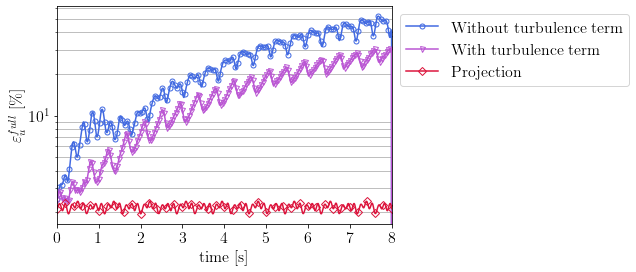

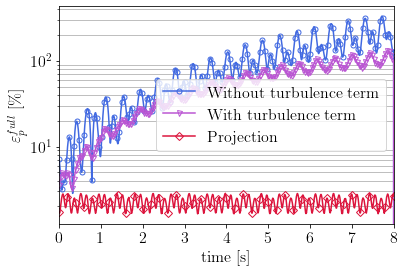

In [32]:
ROM_case = ROM(Nu,Nsup,Np,Nnut,Ru)
ROM_caseT = ROM(Nu,Nsup,Np,Nnut,Ru_T)
ROM_caseT.train_w([256,64],1500,500,1e-5, nn.ReLU)

ROM_case.solveOnline(0.004,2001)
ROM_caseT.solveOnline_corr_one(0.004,2001)

U_err_proj = ROM_case.U_proj()
P_err_proj = ROM_case.P_proj()

ROM_cases = [ROM_case, ROM_caseT]
for case in ROM_cases:
    case.errors()
    
colors = ["royalblue","mediumorchid","crimson","lightseagreen","navy"]
markers = ["o","v","D","p","s"]
    
figvel = plt.figure()
ax = figvel.add_subplot(111)
plt.plot(ROM_case.errU_full, color=colors[0],marker=markers[0],markersize=5,markevery=15,label=r'Without turbulence term', fillstyle='none')
plt.plot(ROM_caseT.errU_full, color=colors[1],marker=markers[1],markersize=5,markevery=10,label=r'With turbulence term', fillstyle='none')
plt.plot(U_err_proj, color=colors[2],marker=markers[2],markersize=5,markevery=50,label=r'Projection', fillstyle='none')
plt.ylabel(r'$\varepsilon_u^{full}$ [$\%$]')
ax.set_xticks([0,250,500,750,1000,1250,1500,1750,2000])
ax.set_xticklabels([0,1,2,3,4,5,6,7,8])
ax.set_xlabel('time [s]')
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.xlim(0,2000)
plt.yscale("log")
plt.grid(True, which="both", ls="-")
plt.grid()
plt.show()
figvel.savefig("error_U_PPE.pdf",bbox_inches='tight')

figp = plt.figure()
ax = figp.add_subplot(111)
plt.plot(ROM_case.errP_full, color=colors[0],marker=markers[0],markersize=5,markevery=15,label=r'Without turbulence term', fillstyle='none')
plt.plot(ROM_caseT.errP_full, color=colors[1],marker=markers[1],markersize=5,markevery=10,label=r'With turbulence term', fillstyle='none')
plt.plot(P_err_proj, color=colors[2],marker=markers[2],markersize=5,markevery=50,label=r'Projection', fillstyle='none')
plt.ylabel(r'$\varepsilon_p^{full}$ [$\%$]')
ax.set_xticks([0,250,500,750,1000,1250,1500,1750,2000])
ax.set_xticklabels([0,1,2,3,4,5,6,7,8])
ax.set_xlabel('time [s]')
plt.legend()
plt.xlim(0,2000)
plt.yscale("log")
plt.grid(True, which="both", ls="-")
plt.grid()
plt.show()
figp.savefig("error_P_PPE.pdf",bbox_inches='tight')